In [2]:
#This workbook intends to:
#1. Model the effect of several factors on domestic violence through MCMC
#2. Use inferencing to predict the dv rates in a test set

In [2]:
####### Crime Multifactor v2 - Alpha-Beta Model ##########
#Assumes crime is influenced linearly by each factor(beta scale), with a 






#Part 0 - Data Preprocessing

####### Import Packages #######

import pymc3 as pm
import re
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats


##### Set model variables #######
TESTSIZE=10


##### Independent Variables ########

#Median Weekly Rent (B112) (index=115) ($/weekly)
#Median total household weekly income ($/wk) B115 index=118
#Percent Unemployment B5497(index=5500)
#area_sqkm = size (index=3)
#population B3 (index=6)


###### Import data #######



#Import domestic violence for each LGA
census_values = np.genfromtxt("DVA_Census_Combined.csv", skip_header=2,
                                usecols=[0, 3,4,6,8,9,10], missing_values="NA",
                                delimiter=",")




#convert census data from string
for i in range(len(census_values)):
    
    census_values[i][0]=census_values[i][0]                 #name
    census_values[i][1] = float(census_values[i][1])        #Median Weekly Rent
    census_values[i][2] = float(census_values[i][2])       #Total household weekly income
    census_values[i][3] = float(census_values[i][3])        # Percent Unemployment
    census_values[i][4] = float(census_values[i][4])        #Seperated Males Rate
    census_values[i][5] = float(census_values[i][5])        #DVA Rate
    census_values[i][6] = float(census_values[i][6])        #Population Density
    #print(census_values[i])


####### split into train and test sets #######
training_data = np.zeros((census_values.shape[0]-TESTSIZE,census_values.shape[1]+1))
training_data = census_values[0:-1*TESTSIZE]

test_data = np.zeros((TESTSIZE,census_values.shape[1]+1),dtype=str)
test_data = census_values[int(census_values.shape[0]-TESTSIZE):]


#######pull out individual variables #######

#train

med_weekly_rent_train = [i[1] for i in training_data]
med_total_house_weekly_income_train = [i[2] for i in training_data]
perc_unemployment_train = [i[3] for i in training_data]
sep_males_train = [i[4] for i in training_data]
dva_train = [i[5] for i in training_data]
pop_density_train = [i[6] for i in training_data]

    
#test
med_weekly_rent_test = [i[1] for i in test_data]
med_total_house_weekly_income_test = [i[2] for i in test_data]
perc_unemployment_test = [i[3] for i in test_data]
sep_males_test = [i[4] for i in test_data]
dva_test = [i[5] for i in test_data]
pop_density_test = [i[6] for i in test_data]







/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0,0.5,'Domestic Violence')

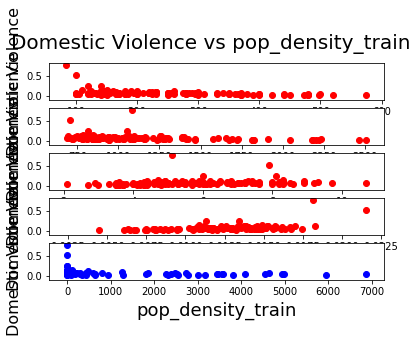

In [3]:
#Part 0 Preprocessing - Data visualisation



fig = plt.figure()

for i in range(len(sep_males_train)):
    plt.scatter(float(sep_males_train[i]),float(dva_train[i]),c="r")

    
fig.suptitle('Domestic Violence vs Seperated Males', fontsize=20)
plt.xlabel('Seperated Males', fontsize=18)
plt.ylabel('Domestic Violence', fontsize=16)

figsize(12.5, 30)


#med_weekly_rent_train 
#med_total_house_weekly_income_train 
#perc_unemployment_train 
#sep_males_train 
#pop_density_train

plt.subplot(5, 1, 1)
for i in range(len(sep_males_train)):
    plt.scatter(float(med_weekly_rent_train[i]),float(dva_train[i]),c="r")
fig.suptitle('Domestic Violence vs med_weekly_rent', fontsize=20)
plt.xlabel('med_weekly_rent', fontsize=18)
plt.ylabel('Domestic Violence', fontsize=16)

plt.subplot(5, 1, 2)
for i in range(len(sep_males_train)):
    plt.scatter(float(med_total_house_weekly_income_train[i]),float(dva_train[i]),c="r")   
fig.suptitle('Domestic Violence vs med_total_house_weekly_income', fontsize=20)
plt.xlabel('med_total_house_weekly_income', fontsize=18)
plt.ylabel('Domestic Violence', fontsize=16)

plt.subplot(5, 1, 3)
for i in range(len(sep_males_train)):
    plt.scatter(float(perc_unemployment_train[i]),float(dva_train[i]),c="r")
fig.suptitle('Domestic Violence vs perc_unemployment', fontsize=20)
plt.xlabel('perc_unemployment', fontsize=18)
plt.ylabel('Domestic Violence', fontsize=16)


plt.subplot(5, 1, 4)
for i in range(len(sep_males_train)):
    plt.scatter(float(sep_males_train[i]),float(dva_train[i]),c="r")
fig.suptitle('Domestic Violence vs Seperated Males', fontsize=20)
plt.xlabel('Seperated Males', fontsize=18)
plt.ylabel('Domestic Violence', fontsize=16)

plt.subplot(5, 1, 5)
for i in range(len(sep_males_train)):
    plt.scatter(float(pop_density_train[i]),float(dva_train[i]),c="b")
fig.suptitle('Domestic Violence vs pop_density_train', fontsize=20)
plt.xlabel('pop_density_train', fontsize=18)
plt.ylabel('Domestic Violence', fontsize=16)



logp = -20,078, ||grad|| = 1,384.4: 100%|██████████| 223/223 [00:00<00:00, 1545.96it/s]       
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [alpha5]
>Metropolis: [alpha4]
>Metropolis: [alpha3]
>Metropolis: [alpha2]
>Metropolis: [alpha1]
>Metropolis: [beta5]
>Metropolis: [beta4]
>Metropolis: [beta3]
>Metropolis: [beta2]
>Metropolis: [beta1]
100%|██████████| 500500/500500 [22:10<00:00, 376.21it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113d50e48>,
      dtype=object)

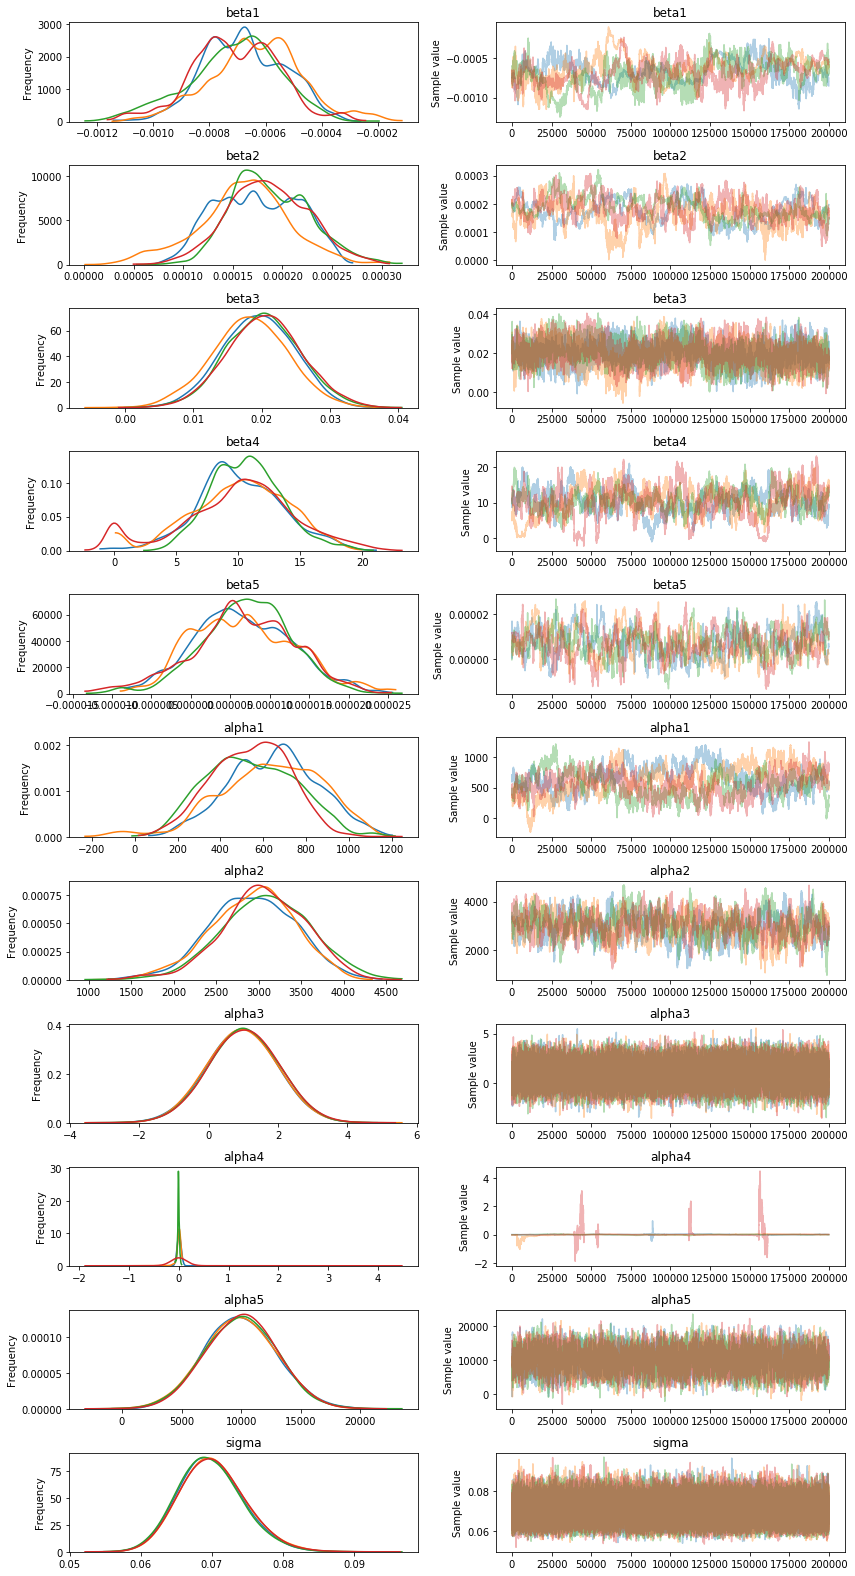

In [7]:
#Part 1 Model Training



#1.1 Prior Estimation 
#Graph each variable against crime for an estimate of its prior
#this is based on the graphs above

#assume each factor is linearly related by some scaling factor B
#Crime = B1*Rent + B2*Income + B3*Unemployment + B4*Sep_Males + B5*Pop_Density + sigma

#med_weekly_rent_train 
#med_total_house_weekly_income_train 
#perc_unemployment_train 
#sep_males_train 
#pop_density_train


#Assume normal distributions
basic_model = pm.Model()

with basic_model:
    beta1 = pm.Normal('beta1',mu=-200,sd=100)
    beta2 = pm.Normal('beta2',mu=-5000,sd=2000)
    beta3 = pm.Normal('beta3',mu=10,sd=50)
    beta4 = pm.Normal('beta4',mu=20,sd=10)
    beta5 = pm.Normal('beta5',mu=-10000,sd=50)
    
    alpha1 = pm.Normal('alpha1',mu=600,sd=200)
    alpha2 = pm.Normal('alpha2',mu=3000,sd=500)
    alpha3 = pm.Normal('alpha3',mu=1,sd=1)
    alpha4 = pm.Normal('alpha4',mu=0,sd=2)
    alpha5 = pm.Normal('alpha5',mu=10000,sd=3000)
    
    sigma = pm.HalfNormal('sigma',sd=5)

    mu = \
    beta1*(med_weekly_rent_train-alpha1)+\
    beta2*(med_total_house_weekly_income_train-alpha2) + \
    beta3*(perc_unemployment_train-alpha3) +\
    beta4*(sep_males_train-alpha4)+\
    beta5*(pop_density_train-alpha5)

    output = pm.Normal('output',mu=mu,sd=sigma,observed=dva_train)

#run simulation
with basic_model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(500000, step=step, start=start)
    burned_trace = trace[100000::2]
    
    
    
pm.traceplot(burned_trace)







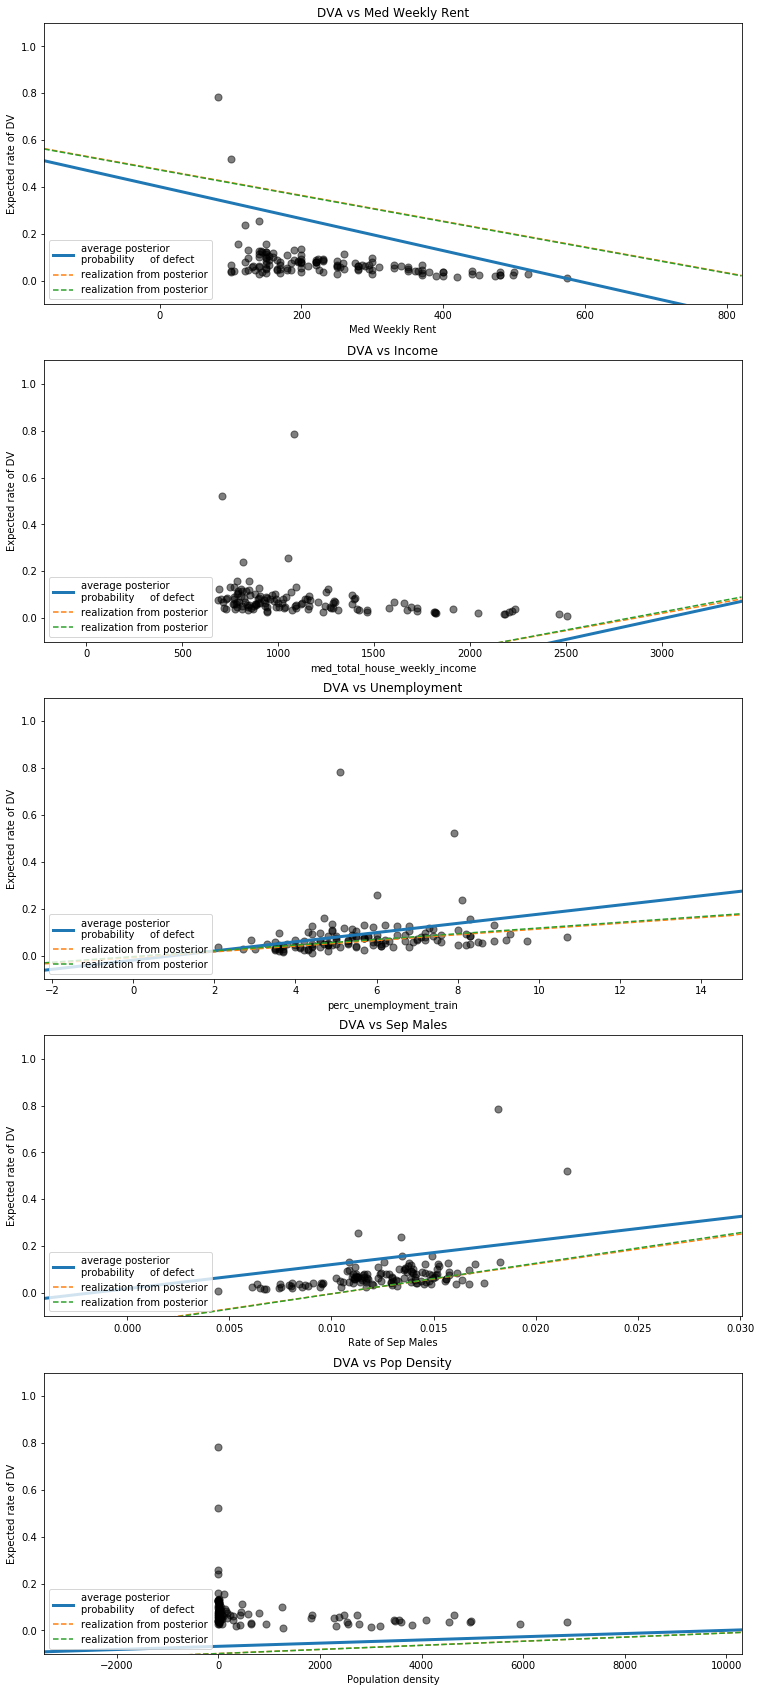

In [8]:
### Part 1.2 Display Model Outputs (Independent Factor Analysis) ###


#equation to caluclate domestic violence
def calcDV(beta1,beta2,beta3,beta4,beta5,rent,income,unemp,sep_males,density):
    return beta1*rent+beta2*income + beta3*unemp +beta4*sep_males+beta5*density


def printOutput(lstName,alphasamples,betasamples,output,title,xaxis):
    #range for testing over seperated males
    mx = max(lstName)
    mn = min(lstName)
    t = np.linspace(mn-(mx-mn)/2,mx+(mx-mn)/2,100)[:,None]
    p_t = (t.T-alphasamples)*betasamples
    mean_prob_t = p_t.mean(axis=0)



    

    plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
    of defect")
    plt.plot(t, p_t[-3, :], ls="--", label="realization from posterior")
    plt.plot(t, p_t[-5, :], ls="--", label="realization from posterior")
    plt.scatter(lstName, output, color="k", s=50, alpha=0.5)
    plt.title(title)
    plt.legend(loc="lower left")
    plt.ylim(-0.1, 1.1)
    plt.xlim(t.min(), t.max())
    plt.ylabel("Expected rate of DV")
    plt.xlabel(xaxis);

alpha1_samples = burned_trace["alpha1"][:, None]  # best to make them 1d
alpha2_samples = burned_trace["alpha2"][:, None]  # best to make them 1d
alpha3_samples = burned_trace["alpha3"][:, None]  # best to make them 1d
alpha4_samples = burned_trace["alpha4"][:, None]  # best to make them 1d
alpha5_samples = burned_trace["alpha5"][:, None]  # best to make them 1d

beta1_samples = burned_trace["beta1"][:, None]  # best to make them 1d
beta2_samples = burned_trace["beta2"][:, None]  # best to make them 1d
beta3_samples = burned_trace["beta3"][:, None]  # best to make them 1d
beta4_samples = burned_trace["beta4"][:, None]  # best to make them 1d
beta5_samples = burned_trace["beta5"][:, None]  # best to make them 1d



sigma_samples = burned_trace["sigma"][:, None]

figsize(12.5, 30)
plt.subplot(5, 1, 1)
printOutput(med_weekly_rent_train,alpha1_samples,beta1_samples,dva_train,"DVA vs Med Weekly Rent","Med Weekly Rent")
plt.subplot(5, 1, 2)
printOutput(med_total_house_weekly_income_train,alpha2_samples,beta2_samples,dva_train,"DVA vs Income","med_total_house_weekly_income")
plt.subplot(5, 1, 3)
printOutput(perc_unemployment_train,alpha3_samples,beta3_samples,dva_train,"DVA vs Unemployment","perc_unemployment_train")
plt.subplot(5, 1, 4)
printOutput(sep_males_train,alpha4_samples,beta4_samples,dva_train,"DVA vs Sep Males","Rate of Sep Males")
plt.subplot(5, 1, 5)
printOutput(pop_density_train,alpha5_samples,beta5_samples,dva_train,"DVA vs Pop Density","Population density")



#mu_samples = (t.T-alpha_samples)*beta_samples
#print(mu_samples)
#plt.subplot(211)
#plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
#plt.hist(mu_samples, histtype='stepfilled', bins=35, alpha=0.85,
#         label=r"posterior of $\beta$",  normed=True)



#plt.plot(mu_samples)
#p_t = pm.Normal(t)

100 130


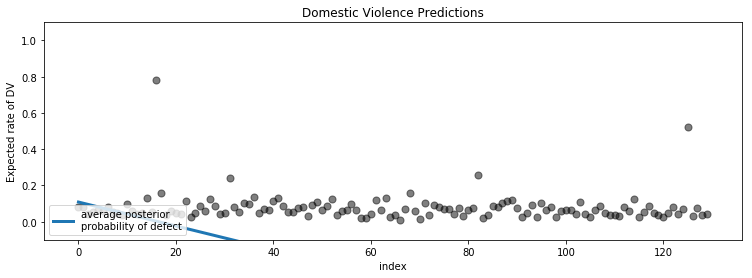

In [142]:
#display combined factor output (difficult with 5 variables)


mx = max(med_weekly_rent_train)
mn = min(med_weekly_rent_train)
t_1 = np.linspace(mn-(mx-mn)/2,mx+(mx-mn)/2,100)[:,None]
mean_prob_t = p_t.mean(axis=0)

mx = max(med_total_house_weekly_income_train)
mn = min(med_total_house_weekly_income_train)
t_2 = np.linspace(mn-(mx-mn)/2,mx+(mx-mn)/2,100)[:,None]
mean_prob_t = p_t.mean(axis=0)

mx = max(perc_unemployment_train)
mn = min(perc_unemployment_train)
t_3 = np.linspace(mn-(mx-mn)/2,mx+(mx-mn)/2,100)[:,None]
mean_prob_t = p_t.mean(axis=0)

mx = max(sep_males_train)
mn = min(sep_males_train)
t_4 = np.linspace(mn-(mx-mn)/2,mx+(mx-mn)/2,100)[:,None]
mean_prob_t = p_t.mean(axis=0)

mx = max(pop_density_train)
mn = min(pop_density_train)
t_5 = np.linspace(mn-(mx-mn)/2,mx+(mx-mn)/2,100)[:,None]
mean_prob_t = p_t.mean(axis=0)


#calc eq
p_t = beta1_samples*t_1.T
#+beta2_samples*t_2+beta3_samples*t_3+beta4_samples*t_4+beta5_samples*t_5
mean_prob_t = p_t.mean(axis=0)

t=[]
for i in range(100):
    t.append(i)

t130=[]
for i in range(130):
    t130.append(i)
    
    
    #    mx = max(lstName)
    #mn = min(lstName)
    #t = np.linspace(mn-(mx-mn)/2,mx+(mx-mn)/2,100)[:,None]
    #p_t = t.T*beta1_samples

figsize(12.5, 4)
print(len(t),len(dva_train))
plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
#plt.plot(t130[, p_t[-3, :], ls="--", label="realization from posterior")
#plt.plot(t, p_t[-5, :], ls="--", label="realization from posterior")
plt.scatter(t130, dva_train, color="k", s=50, alpha=0.5)
plt.title("Domestic Violence Predictions")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
#plt.xlim(t.min(), t.max())
plt.ylabel("Expected rate of DV")
plt.xlabel("index");



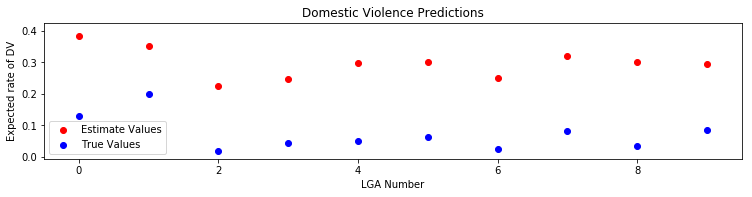

In [6]:
###### Part 2 - Inferencing ########


#calculate estimated values for the test set based on the trace values
dva_estimates = []
for i in range(len(dva_test)):
    dva_estimate = calcDV(beta1_samples,beta2_samples,beta3_samples,beta4_samples,beta5_samples,med_weekly_rent_test[i],med_total_house_weekly_income_test[i],perc_unemployment_test[i],sep_males_test[i],pop_density_test[i]).mean()
    dva_estimates.append(dva_estimate)

#compare against an index
t = [i for i in range(len(dva_test))]

#plot the comparison
figsize(12.5, 2.5)
plt.scatter(t,dva_estimates,c="r",label="Estimate Values")
plt.scatter(t,dva_test,c="b",label="True Values")

plt.title("Domestic Violence Predictions")
plt.legend(loc="lower left")
plt.ylabel("Expected rate of DV")
plt.xlabel("LGA Number");

    